## Praca Domowa 1
### Autor: Tymoteusz Barciński

### Na podstawie materiałów Huberta Banieckiego
https://github.com/MI2-Education/2022L-WB-XIC/blob/main/labs/lab2/code.ipynb 
https://github.com/MI2-Education/2022L-WB-XIC/blob/main/labs/lab3/code.ipynb

In [157]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import torchvision
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import tqdm 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### XOR

In [68]:
torch.manual_seed(1)
np.random.seed(1)

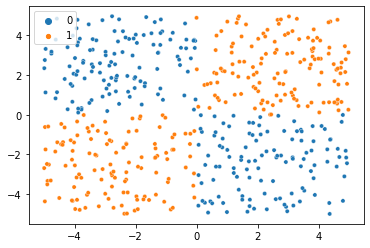

In [233]:
n = 500
X = np.random.uniform(low=-5, high=5, size=(n,2))
y = np.where(
    (((X[:, 0] > 0) & (X[:, 1] > 0)) | ((X[:, 0] < 0) & (X[:, 1] < 0))),
    1,0)
sns.scatterplot(
    x = X[:, 0],
    y = X[:, 1],
    size = 1,
    hue=y
)
plt.show()

In [234]:
X_train_xor, X_test_xor, y_train_xor, y_test_xor = train_test_split(
    X, y, random_state=42, shuffle=True, stratify = y, test_size = 0.3)

X_train_xor = torch.as_tensor(X_train_xor, dtype=torch.float32)
X_test_xor = torch.as_tensor(X_test_xor, dtype=torch.float32)
y_train_xor = torch.as_tensor(y_train_xor, dtype=torch.long)
y_test_xor = torch.as_tensor(y_test_xor, dtype=torch.long)

### Iris

In [166]:
X, y = load_iris(return_X_y=True)
num_inputs = X.shape[1]
num_outputs = np.unique(y).size

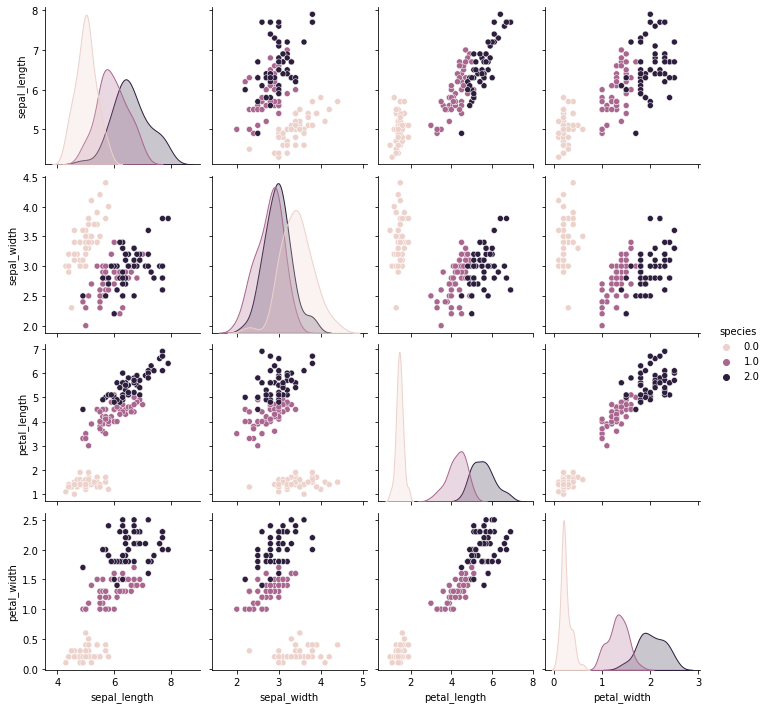

In [192]:
df = pd.DataFrame(np.column_stack((X, y)))
df = df.rename(columns={
    0: 'sepal_length', 1:'sepal_width', 2:'petal_length',3:'petal_width', 4:'species'})

sns.pairplot(
    data=df,
    vars=('sepal_length','sepal_width','petal_length','petal_width'),
    hue='species'
    )

In [167]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X, y, random_state=42, shuffle=True, stratify = y)

scaler = StandardScaler()
X_train_iris = scaler.fit_transform(X_train_iris)
X_test_iris = scaler.transform(X_test_iris)

In [168]:
X_train_iris = torch.as_tensor(X_train_iris, dtype=torch.float32)
X_test_iris = torch.as_tensor(X_test_iris, dtype=torch.float32)
y_train_iris = torch.as_tensor(y_train_iris, dtype=torch.long)
y_test_iris = torch.as_tensor(y_test_iris, dtype=torch.long)

### Sieć Neuronowa

In [160]:
# https://github.com/d2l-ai/d2l-ko/blob/master/chapter_linear-networks/linear-regression-scratch_origin.md

import random

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [161]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

In [169]:
def training_function(
    net, learning_rate, batch_size, num_iter,
    X_test, y_test, X_train, y_train,
    loss,
    ):

    losses = []
    errors_train = []
    errors_test = []

    net.apply(init_weights)

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

    for epoch in tqdm.tqdm(range(num_iter)):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []
        
        for X, y in data_iter(batch_size, X_test, y_test):
            y_predicted = net(X)                                                        # feedforward
            errors_test_iter += [(y != y_predicted.argmax(1)).float().mean().item()]    # finding out which ones are misclassified

        for X, y in data_iter(batch_size, X_train, y_train):
            y_predicted = net(X)                                                        # feedforward
            errors_train_iter += [(y != y_predicted.argmax(1)).float().mean().item()]   # finding out which ones are misclassified
            l = loss(y_predicted, y)                                                    # calculting loss function
            optimizer.zero_grad()                                                       # setting gradient to zero
            l.mean().backward()                                                         # calculating backward step- derivatitves dl/dw 
            losses_iter += [l.mean().item()]                                            # keeping track of the average losses
            optimizer.step()                                                            # actually doing backward propagation - updating weigths
        
        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]
        losses += [np.mean(losses_iter)]

    return errors_train, errors_test, losses, num_iter

In [170]:
def plot_learning_curves(
    net_input, learning_rate, batch_size,
    X_test, y_test, X_train, y_train,
    loss = torch.nn.CrossEntropyLoss(reduction='none'),
    num_iter = 100):

    errors_train, errors_test, losses, num_iter = training_function(
        net = net_input,
        learning_rate = learning_rate,
        num_iter = num_iter,
        batch_size = batch_size,
        X_test = X_test, y_test = y_test,
        X_train = X_train, y_train = y_train,
        loss = loss
    )

    plt.figure(figsize=(12, 8))
    plt.plot(range(num_iter), errors_train)
    plt.plot(range(num_iter), errors_test)
    plt.plot(range(num_iter), losses)
    plt.title(f"Learning curves; learning_rate: {learning_rate}, batch_size: {batch_size}")
    plt.legend(['Error_train', 'Error_test', 'Loss'])
    plt.show()

## Iris

### Liczba neurownów w warstwie

In [175]:
net1 = torch.nn.Sequential( 
    torch.nn.Flatten(),  
    torch.nn.Linear(4, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3)
)

100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


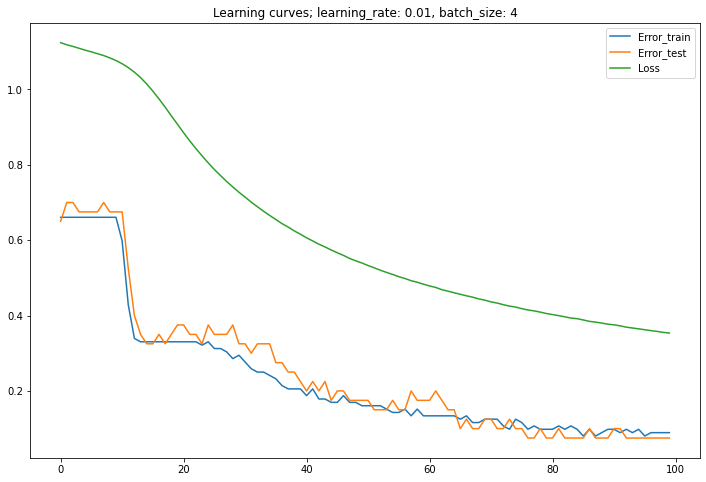

In [176]:
plot_learning_curves(
    net1, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

In [177]:
net2 = torch.nn.Sequential( 
    torch.nn.Flatten(),  
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 3)
)

100%|██████████| 100/100 [00:03<00:00, 30.14it/s]


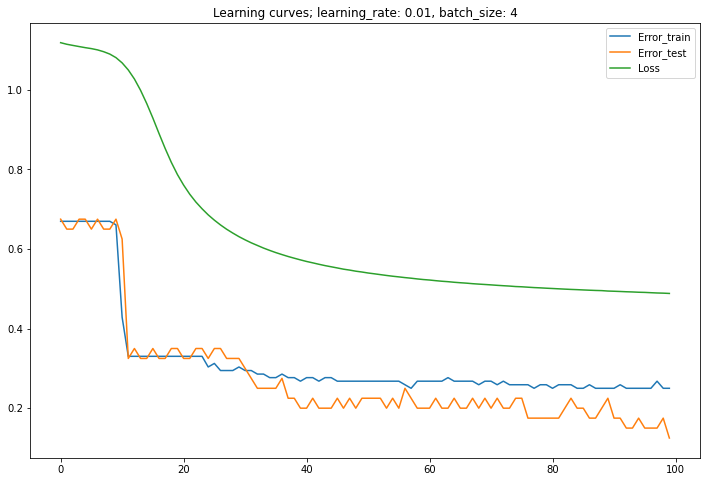

In [178]:
plot_learning_curves(
    net2, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

In [179]:
net3 = torch.nn.Sequential( 
    torch.nn.Flatten(),  
    torch.nn.Linear(4, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 3)
)

100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


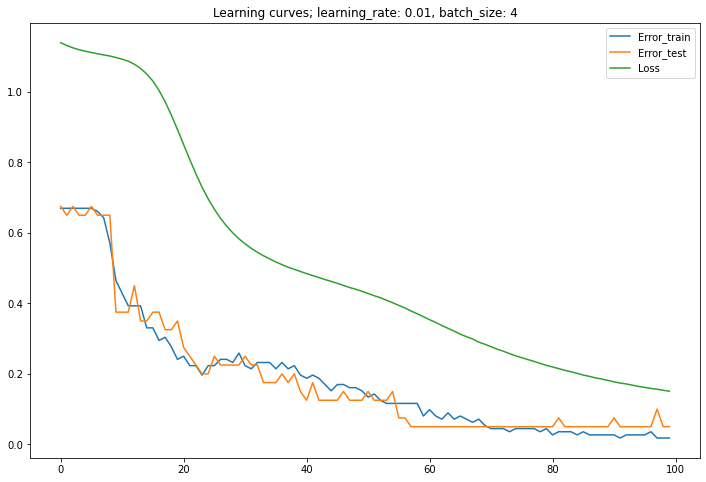

In [180]:
plot_learning_curves(
    net3, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

### Liczba warstw

In [205]:
net4 = torch.nn.Sequential( 
    torch.nn.Flatten(),  
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 3)
)

100%|██████████| 100/100 [00:03<00:00, 30.47it/s]


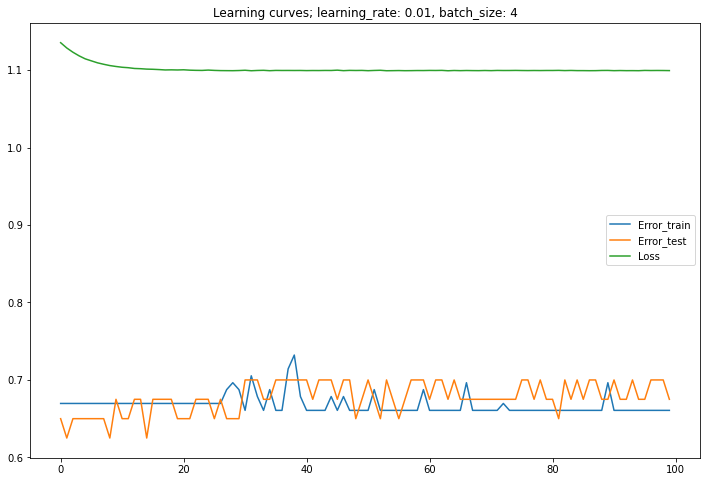

In [206]:
plot_learning_curves(
    net4, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

In [207]:
net5 = torch.nn.Sequential( 
    torch.nn.Flatten(),  
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 3)
)

100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


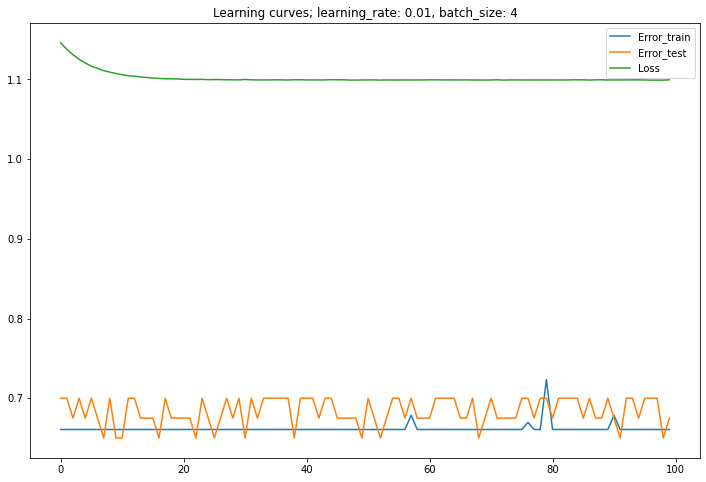

In [198]:
plot_learning_curves(
    net5, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

### Learning rate

100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


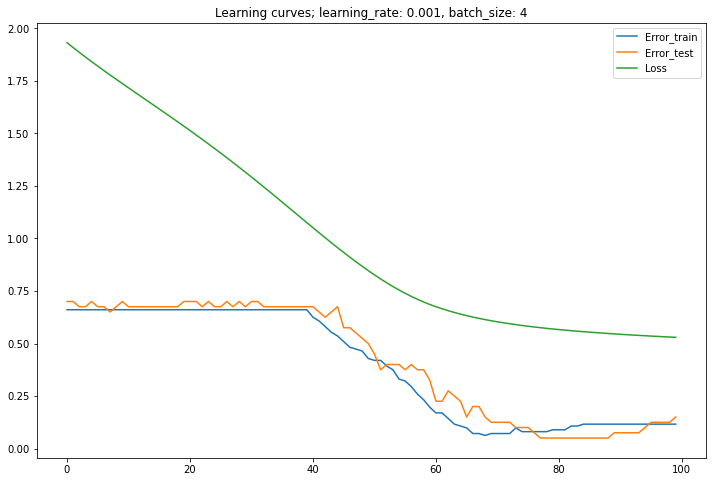

In [185]:
plot_learning_curves(
    net1, learning_rate = 0.001, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]


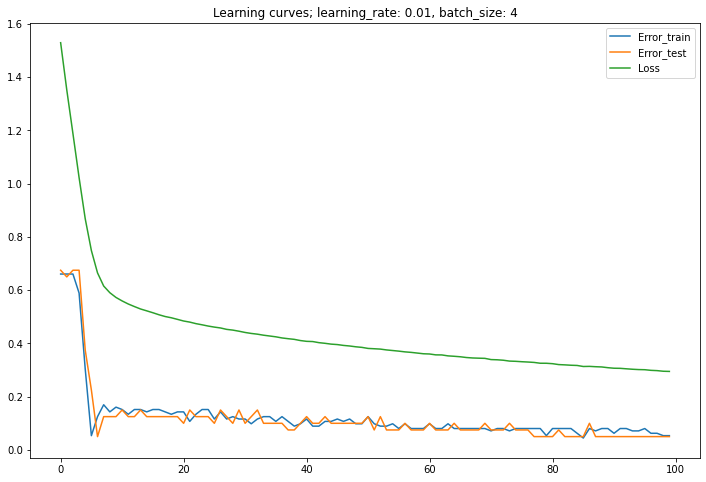

In [186]:
plot_learning_curves(
    net1, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


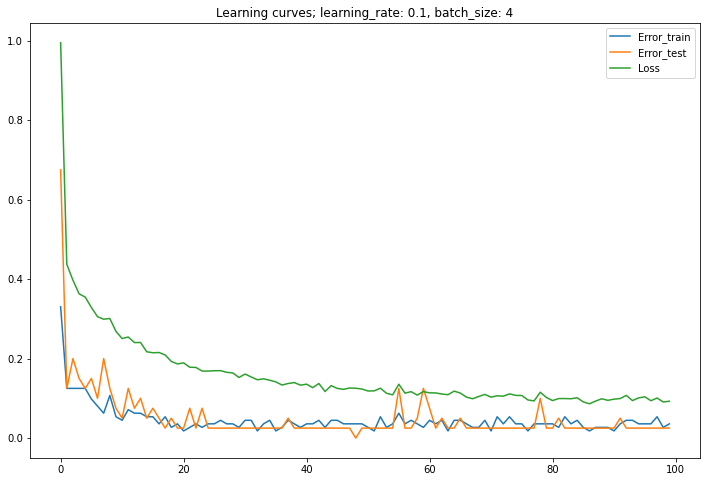

In [187]:
plot_learning_curves(
    net1, learning_rate = 0.1, batch_size = 4, num_iter=100,
    X_train=X_train_iris, X_test=X_test_iris, y_train=y_train_iris, y_test=y_test_iris
)

### Wnioski
1.	Różnica pomiędzy błędem zbioru treningowego a testowego nie zależy od ilości neuronów w warstwie ukrytej. Błędy te osiągnęły zadowalający poziom w procesie uczenia.
2.	Zaskakująco, większa liczba warstw sieci powoduje utratę wartości predykcyjnej. 
3.	Strata dla kolejnych epok maleje szybciej dla mniejszych wartości learning rate. Różnica pomiędzy błędem zbioru treningowego a testowego nie zależy od wartości learning rate.


## XOR

### Liczba neuronów w wartstwie

In [125]:
net1 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
)

100%|██████████| 200/200 [00:27<00:00,  7.26it/s]


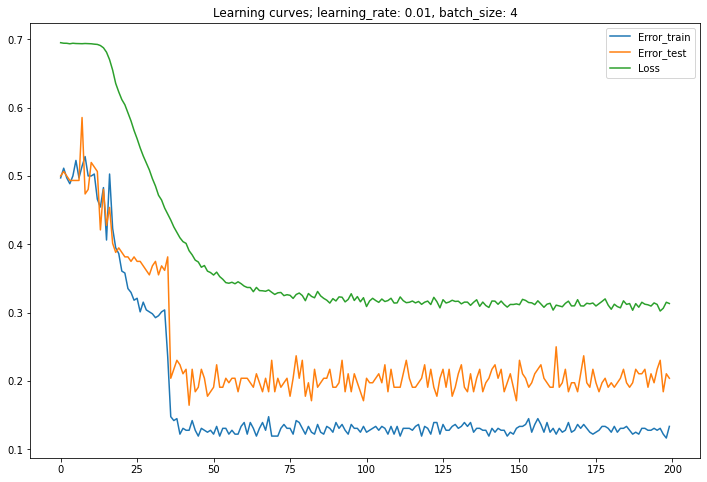

In [126]:
plot_learning_curves(
    net1, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
)

In [139]:
net2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 2),
)

100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


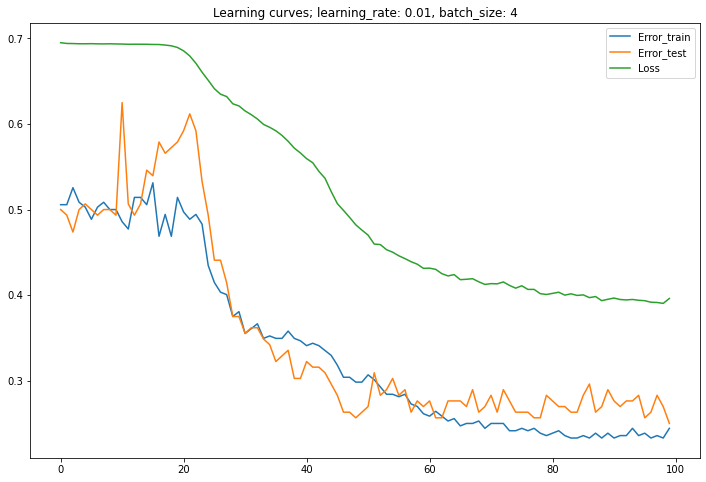

In [140]:
plot_learning_curves(
    net2, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

In [240]:
net3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(2, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 2),
)

100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


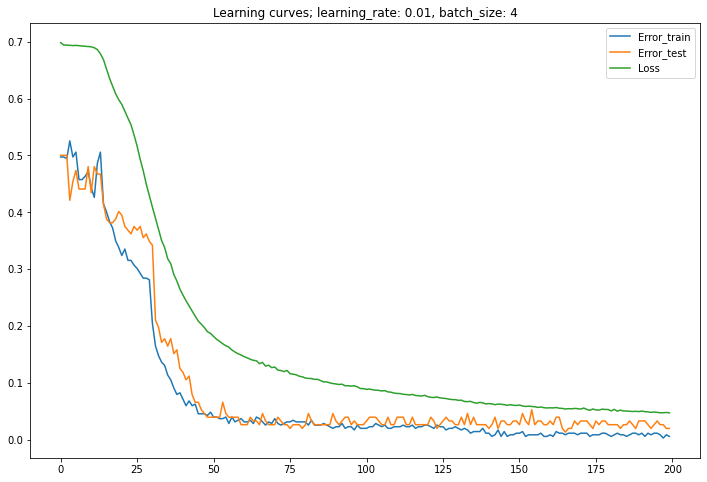

In [133]:
plot_learning_curves(
    net3, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

### Liczba warstw

In [228]:
net4 = torch.nn.Sequential(
    torch.nn.Linear(2, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 2),
)

100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


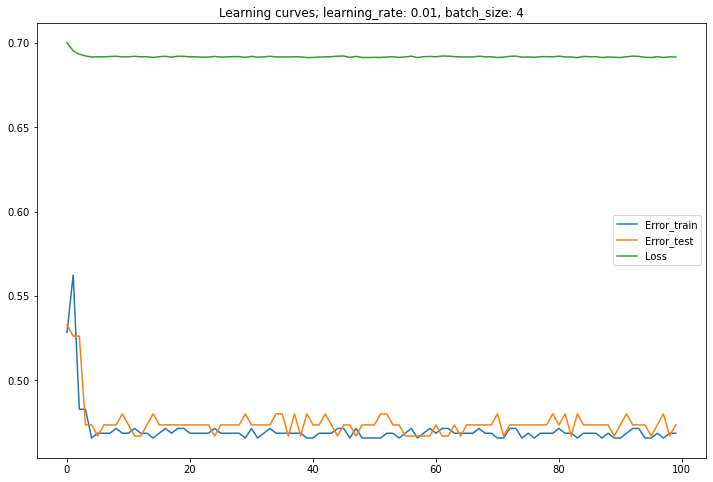

In [229]:
plot_learning_curves(
    net4, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

In [236]:
net5 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(2, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 2),
)

100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


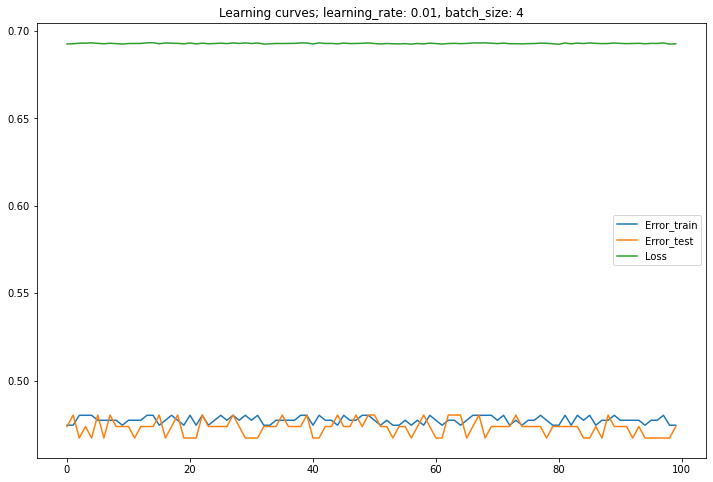

In [238]:
plot_learning_curves(
    net5, learning_rate = 0.01, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

### Learning rate

100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


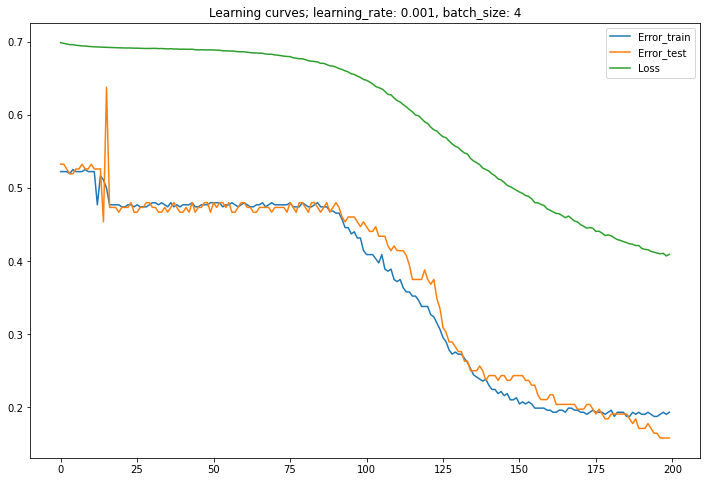

In [242]:
plot_learning_curves(
    net3, learning_rate = 0.001, batch_size = 4, num_iter=200,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


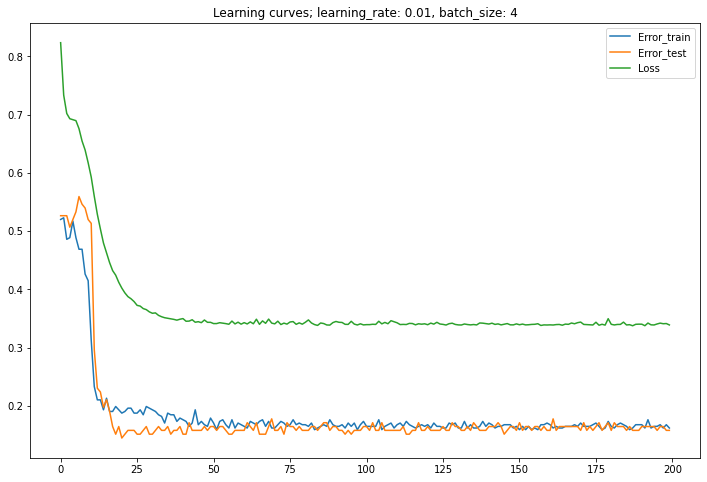

In [243]:
plot_learning_curves(
    net3, learning_rate = 0.01, batch_size = 4, num_iter=200,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


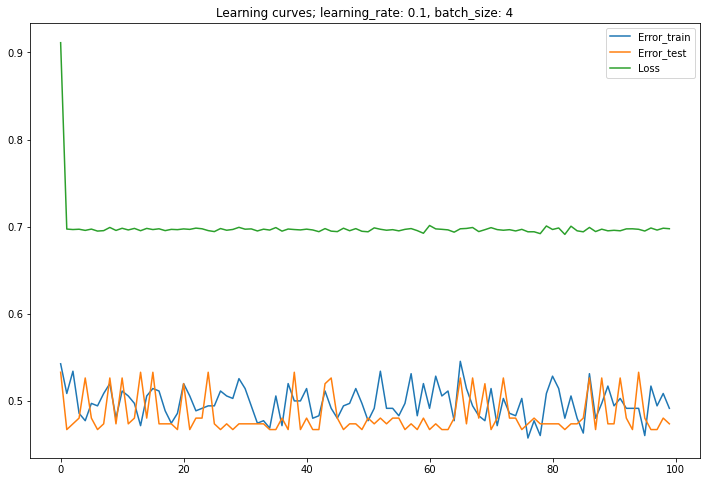

In [244]:
plot_learning_curves(
    net3, learning_rate = 0.1, batch_size = 4, num_iter=100,
    X_test = X_test_xor, X_train = X_train_xor, y_train = y_train_xor, y_test = y_test_xor
    )

## Wnioski
1.	Wraz ze wzrostem liczby neuronów w warstwie różnica pomiędzy błędem zbioru treningowego a testowego maleje. 
2.	Zaskakująco, większa liczba warstw sieci powoduje utratę wartości predykcyjnej. 
3.	Dla dużej wartości learning rate model traci zdolności predykcyjne. Natomiast dla mniejszych wartości są one na satysfakcjonującym poziomie.
